In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
ll_crs = 'EPSG:4326'
m_crs = 'EPSG:3310'

# data upload

In [69]:
AADT = gpd.read_file('raw_datasets/Traffic_Volumes_AADT/Traffic_Volumes_AADT.shp').to_crs(ll_crs)
counties = gpd.read_file('raw_datasets/ca_counties/ca_counties.shp').to_crs(ll_crs)
coast = gpd.read_file('raw_datasets/3853-s3_2002_s3_reg_pacific_ocean-shapefile/3853-s3_2002_s3_reg_pacific_ocean.shp').to_crs(ll_crs)
ps_roads = gpd.read_file('raw_datasets/tl_2024_06_prisecroads/tl_2024_06_prisecroads.shp').to_crs(ll_crs)
public_access = gpd.read_file('raw_datasets/Public_Access_Points/Public_Access_Points.shp').to_crs(ll_crs)

# cleaning counties

In [70]:
keys = ['sd', 'ora', 'la', 'ven', 'sb', 'slo', 'mon', 'scr']
county_keys = {'sd': 'San Diego',
               'ora': 'Orange',
               'la': 'Los Angeles',
               'ven': 'Ventura',
               'sb': 'Santa Barbara',
               'slo': 'San Luis Obispo',
               'mon': 'Monterey',
               'scr': 'Santa Cruz'}

In [71]:
county_names = [county_keys[key] for key in keys]
counties = counties.loc[[(name in county_names) for name in counties.NAME]].reset_index(drop=True)
#counties

In [72]:
len(counties)

8

In [73]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-120.7343 34.90069, -120.73431..."
1,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-119.32923 34.22784, -119.3292..."
2,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,348,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,"MULTIPOLYGON (((-118.7034 34.1686, -118.70338 ..."
3,06,073,00277301,06073,San Diego,San Diego County,06,H1,G4020,None,41740,None,A,1.090437e+10,8.174046e+08,+33.0236041,-116.7761174,553042.602989,1.672201e+10,"POLYGON ((-117.43744 33.17953, -117.44955 33.1..."
4,06,053,00277291,06053,Monterey,Monterey County,06,H1,G4020,None,41500,None,A,8.499617e+09,1.267800e+09,+36.2401070,-121.3155723,742255.971048,1.504587e+10,"POLYGON ((-122.02682 36.54641, -122.02703 36.5..."


# cleaning coastline

In [74]:
coast_boundary = coast.geometry.boundary

<Axes: >

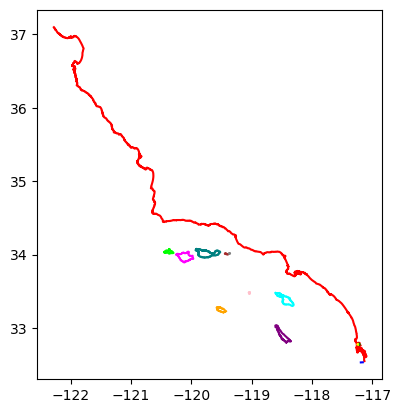

In [75]:
south_coast = coast_boundary.geometry.intersection(counties.geometry.union_all())
south_coast = gpd.GeoDataFrame(geometry=south_coast.explode(), crs=coast.crs)
south_coast['color'] = [
    'red', 'blue', 'green', 'yellow', 'purple', 
    'orange', 'pink', 'cyan', 'magenta', 'brown', 
    'gray', 'lime', 'teal'
]
south_coast.plot(color=south_coast['color'])

<Axes: >

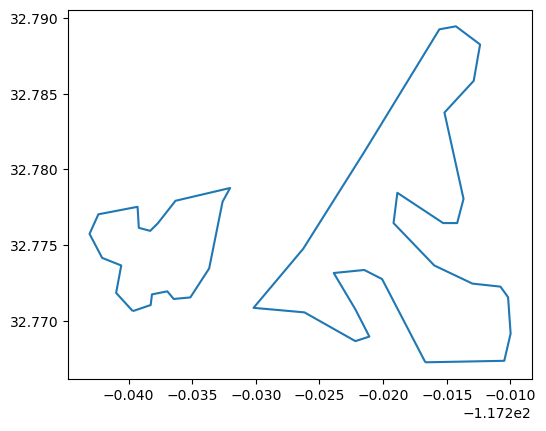

In [76]:
# these are fiesta island and vacation isle within Mission Bay
islands = south_coast.loc[(south_coast.color == 'yellow') | (south_coast.color == 'green')]
islands.plot()

In [77]:
# Filter mainland_coast based on color values
mainland_coast = south_coast.loc[south_coast.color == 'red']
mainland_coast.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [78]:
from shapely.geometry import Polygon

coords = [(-122.5,37.5), (-122.5,32.4), (-116,32.4), (-116,37.5)]
polygon = Polygon(coords)

# Create a GeoDataFrame to handle and visualize the Polygon
gdf = gpd.GeoDataFrame({'geometry': [polygon]})

# Set a Coordinate Reference System (CRS) if necessary (e.g., EPSG:4326 for lat/lon)
gdf = gdf.set_crs(ll_crs)

<Axes: >

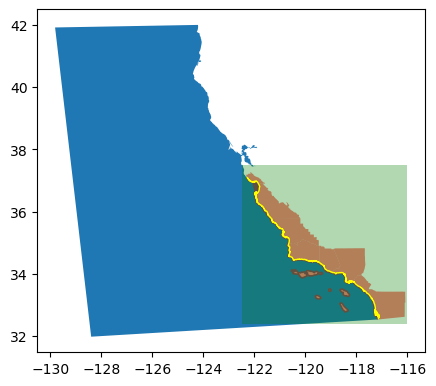

In [79]:
fig, ax = plt.subplots(figsize=(5,5))

coast.plot(ax=ax)
counties.plot(ax=ax, color='red', alpha=0.5)
mainland_coast.plot(ax=ax, color='yellow', linewidth=1)
gdf.plot(ax=ax, color='green', alpha = 0.3)

In [80]:
# save a small version of the coastline for plotting purposes
small_coast = coast.geometry.intersection(gdf.geometry.union_all())
small_coast = gpd.GeoDataFrame(geometry=small_coast, crs=coast.crs)

In [81]:
# save data
mainland_coast.to_file('clean_data/coastline/mainland_coast.shp')
small_coast.to_file('clean_data/coastline/small_coast.shp')

# cleaning public access points

In [16]:
# only keep access points in the proper counties
public_access = public_access.loc[public_access.geometry.intersects(counties.geometry.union_all())]

In [17]:
# only keep public access points within 200 m of the beach and in appropriate counties
mainland_coast = mainland_coast.to_crs(m_crs)
buffer = mainland_coast.geometry[0].buffer(200)

# only mainland public beach access within 200m of the beach itself
beach_access = public_access.to_crs(m_crs)
beach_access = beach_access.loc[beach_access.geometry.intersects(buffer)]
len(beach_access)

719

In [18]:
#beach_access.FeatureTyp.value_counts()

In [19]:
# these were manually selected
good_features = [
    'Physical Access', 'City/County Park', 'National/State/Regional Park/Beach/Rec Area', 'Waterfront Features',
    'Path/Trail/Drive', 'Nature Preserve/Reserve', 'GP - Harbor', 'GP - MPA', 'Water Feature', 'Physical Access/Recreational Facility',
    'Waterfront Feature', 'Park & Physical Access'
]
bad_features = [
    'Facility', 'Visual Access', 'Recreational Facility', 'GP - Town/City', 'Architectural Feature', 'Historic Feature',
    'GP - waterbody', 'Physical and Visual Acces', 'GP - Island', 'Land Feature', 'Bridge', 'Historic Waterfront Features',
    'GP - Facility', 'Lodging Facility', 'Waterfront Facility'
]

In [20]:
beach_access = beach_access.loc[beach_access.FeatureTyp.isin(good_features)]
len(beach_access)

606

In [21]:
'''t = 'Waterfront Facility'
sub = beach_access.loc[beach_access.FeatureTyp == t]
sub'''

"t = 'Waterfront Facility'\nsub = beach_access.loc[beach_access.FeatureTyp == t]\nsub"

In [22]:
'''fig, ax = plt.subplots(figsize=(7,7))

small_coast.plot(ax=ax)
sub.plot(ax=ax, markersize=3, color='red')'''

"fig, ax = plt.subplots(figsize=(7,7))\n\nsmall_coast.plot(ax=ax)\nsub.plot(ax=ax, markersize=3, color='red')"

In [23]:
# save file
beach_access.to_file('clean_data/beach_access/beach_access.shp')

# cleaning roads

the goal is to get (1) the nearest road to the beach_access points and (2) get the nearest primary or secondary road to each of those points

## cleaning access roadpoints

In [24]:
# all roads
roads = {}
roads['sd'] = gpd.read_file('raw_datasets/all_roads/sd/tl_2024_06073_roads.shp').to_crs(ll_crs)
roads['ora'] = gpd.read_file('raw_datasets/all_roads/ora/tl_2024_06059_roads.shp').to_crs(ll_crs)
roads['la'] = gpd.read_file('raw_datasets/all_roads/la/tl_2024_06037_roads.shp').to_crs(ll_crs)
roads['ven'] = gpd.read_file('raw_datasets/all_roads/ven/tl_2024_06111_roads.shp').to_crs(ll_crs)
roads['sb'] = gpd.read_file('raw_datasets/all_roads/sb/tl_2024_06083_roads.shp').to_crs(ll_crs)
roads['slo'] = gpd.read_file('raw_datasets/all_roads/slo/tl_2024_06079_roads.shp').to_crs(ll_crs)
roads['mon'] = gpd.read_file('raw_datasets/all_roads/mon/tl_2024_06053_roads.shp').to_crs(ll_crs)
roads['scr'] = gpd.read_file('raw_datasets/all_roads/scr/tl_2024_06087_roads.shp').to_crs(ll_crs)

for key in keys:
    roads[key]['COUNTY'] = [key.upper()] * len(roads[key])

all_roads = pd.concat([roads[key] for key in keys], ignore_index=True)
all_roads.head()

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry,COUNTY
0,110686150541,Friars Rd Rmp,M,S1400,"LINESTRING (-117.16291 32.77078, -117.16295 32...",SD
1,11016955162933,St Exd,M,S1400,"LINESTRING (-116.20903 32.61042, -116.20309 32...",SD
2,1103663798504,McGavran Dr Exn,M,S1400,"LINESTRING (-117.25959 33.18698, -117.25948 33...",SD
3,1103663797349,McGavran Dr Exn,M,S1400,"LINESTRING (-117.25862 33.18629, -117.25854 33...",SD
4,1103279037929,Tower Dr Exn,M,S1400,"LINESTRING (-117.23159 33.18395, -117.23199 33...",SD


In [25]:
mainland_coast = mainland_coast.to_crs(m_crs)

# reduce search area to 1 km from the coast
buffer = mainland_coast.geometry[0].buffer(2 * 1000)
mainland_coast = mainland_coast.to_crs(ll_crs)

In [26]:
all_roads = all_roads.to_crs(m_crs)

# take intersection of roads with coast buffer
coast_roads = all_roads.copy()
coast_roads.geometry = coast_roads.geometry.apply(lambda g: g.intersection(buffer))
coast_roads = coast_roads[~coast_roads.geometry.is_empty].reset_index(drop=True)
coast_roads_union = coast_roads.geometry.union_all()

In [27]:
nearest_roadpoints = beach_access.filter(['Name', 'geometry']).to_crs(m_crs).reset_index(drop=True)
nearest_roadpoints['m_access'] = [None] * len(nearest_roadpoints)

In [28]:
len(nearest_roadpoints)

606

In [29]:
# for each access point, find nearest point on the coast_roads_union geometry
import shapely.ops as sho

for i,g in enumerate(nearest_roadpoints.geometry):
    nearest_roadpoint = sho.nearest_points(g, coast_roads_union)[1]
    nearest_roadpoints.loc[i, 'geometry'] = nearest_roadpoint
    nearest_roadpoints.loc[i, 'm_access'] = g.distance(nearest_roadpoint)
    
nearest_roadpoints.m_access = nearest_roadpoints.m_access.astype(float)
nearest_roadpoints = nearest_roadpoints.to_crs(ll_crs)

In [30]:
len(beach_access), len(nearest_roadpoints)

(606, 606)

<Axes: >

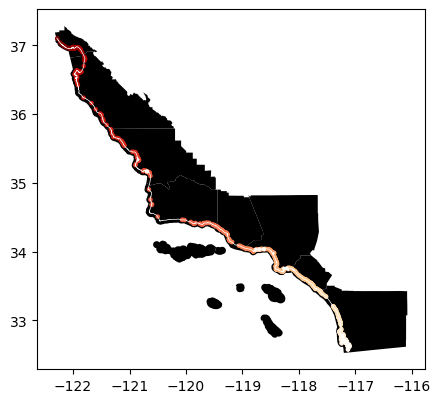

In [31]:
fig, ax = plt.subplots(figsize=(5,5))


counties.plot(ax=ax, color='black')
mainland_coast.plot(ax=ax, color='white', linewidth=0.5)
nearest_roadpoints.plot(ax=ax, c = nearest_roadpoints.m_access, cmap='OrRd_r', markersize=5, legend=True)

In [32]:
# save the nearest_roadpoints
nearest_roadpoints.to_file('clean_data/roads/nearest_access_roads.shp')

In [33]:
nearest_roadpoints.head()

,Name,geometry,m_access
0,Big Basin Redwoods State Park,POINT (-122.27989 37.09822),20.089684
1,Waddell Creek Beach,POINT (-122.27794 37.09625),138.617299
2,Scott Creek Beach,POINT (-122.22921 37.04078),81.132364
3,Davenport Landing Beach,POINT (-122.21542 37.02485),90.647203
4,Davenport Beach,POINT (-122.19255 37.00999),140.193161


In [34]:
nearest_roadpoints.dtypes

Name          object
geometry    geometry
m_access     float64
dtype: object

## cleaning primary and secondary roads

In [35]:
ps_roads = ps_roads.to_crs(ll_crs)
counties = counties.to_crs(ps_roads.crs)

In [37]:
fair = counties.geometry.union_all()
ps_roads.geometry = ps_roads.geometry.apply(lambda g: g.intersection(fair))
ps_roads = ps_roads.loc[~ps_roads.geometry.is_empty].reset_index(drop=True)

In [48]:
import shapely.ops as sho

ps_roads = ps_roads.to_crs(m_crs)
nearest_roadpoints = nearest_roadpoints.to_crs(ps_roads.crs)
ps_network = ps_roads.geometry.union_all()

nearest_highway_points = nearest_roadpoints.filter(['Name', 'geometry']).copy()
nearest_highway_points['m_road'] = [None] * len(nearest_highway_points)

for i,g in enumerate(nearest_roadpoints.geometry):
    nearest_highway_point = sho.nearest_points(g, ps_network)[1]
    dist = g.distance(nearest_highway_point)
    nearest_highway_points.loc[i, 'geometry'] = nearest_highway_point
    nearest_highway_points.loc[i, 'm_road'] = dist

nearest_highway_points = nearest_highway_points.to_crs(ll_crs)

In [49]:
nearest_highway_points.head()

,Name,geometry,m_road
0,Big Basin Redwoods State Park,POINT (-122.2805 37.09754),92.331849
1,Waddell Creek Beach,POINT (-122.27794 37.09625),0.0
2,Scott Creek Beach,POINT (-122.22921 37.04078),0.0
3,Davenport Landing Beach,POINT (-122.21332 37.02619),239.025155
4,Davenport Beach,POINT (-122.19255 37.00999),0.0


In [50]:
# export and save
nearest_highway_points.to_file('clean_data/roads/nearest_highway_points.shp')

# cleaning AADT data

In [82]:
AADT.AHEAD_AADT = AADT.AHEAD_AADT.astype(float)
AADT.BACK_AADT = AADT.BACK_AADT.astype(float)
AADT = AADT.filter(['COUNTY', 'BACK_AADT', 'AHEAD_AADT', 'geometry']).groupby(['COUNTY', 'geometry']).max()

In [83]:
AADT = AADT.reset_index()
AADT = gpd.GeoDataFrame(AADT, geometry=AADT.geometry).set_crs(ll_crs)

In [84]:
keys

['sd', 'ora', 'la', 'ven', 'sb', 'slo', 'mon', 'scr']

In [85]:
AADT = AADT.loc[AADT.COUNTY.str.lower().isin(keys)]

In [86]:
AADT = AADT.loc[~(np.isnan(AADT.AHEAD_AADT) & np.isnan(AADT.BACK_AADT))].reset_index(drop=True)

In [87]:
AADT['traffic'] = AADT[['AHEAD_AADT', 'BACK_AADT']].mean(axis=1)

In [88]:
na_traffic = np.isnan(AADT.traffic)
na_traffic.sum()

0

In [90]:
AADT.traffic.min()

120.0

<Axes: >

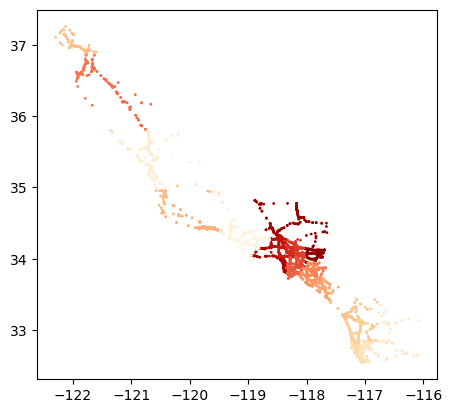

In [91]:
AADT.plot(c=AADT.traffic, cmap='OrRd_r', legend=True, markersize = 1)

In [92]:
# create a 10 km buffer
mainland_coast = mainland_coast.to_crs(m_crs)
buffer_10km = mainland_coast.geometry[0].buffer(10 * 1000)

In [93]:
AADT = AADT.to_crs(mainland_coast.crs)
within_10km_coast = AADT.geometry.intersects(buffer_10km)

In [94]:
within_10km_coast.mean()

0.37002404488378304

In [95]:
AADT['coastal'] = within_10km_coast

In [96]:
AADT = AADT.to_crs(ll_crs)

In [97]:
AADT

,COUNTY,geometry,BACK_AADT,AHEAD_AADT,traffic,coastal
0,LA,POINT (-117.69235 34.1246),168000.0,NaN,168000.0,False
1,LA,POINT (-117.69251 34.12421),168000.0,NaN,168000.0,False
2,LA,POINT (-117.69668 34.1216),151000.0,160000.0,155500.0,False
3,LA,POINT (-117.69625 34.12159),151000.0,160000.0,155500.0,False
4,LA,POINT (-117.71941 34.08166),265000.0,265000.0,265000.0,False
...,...,...,...,...,...,...
3738,VEN,POINT (-119.08195 34.11236),8800.0,8800.0,8800.0,True
3739,VEN,POINT (-118.63555 34.26786),101000.0,100000.0,100500.0,False
3740,VEN,POINT (-118.6357 34.268),101000.0,100000.0,100500.0,False
3741,VEN,POINT (-118.6334 34.26958),100000.0,NaN,100000.0,False


In [98]:
# save file and export
AADT.to_file('clean_data/AADT/AADT.shp')